# Final Project: Meal Nurtition Analysis

## Libraries and Packages Used in the Project
For this project we are using PyTorch for model implementation and training, while Keras is utilized solely for data preprocessing tasks.

In [1]:
pip install keras


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import torch
import ast
from PIL import Image
import torchvision.transforms as transforms
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder

<br></br>
## (a) Data Preprocessing

### Preprocessing Training and Testing Image Data

#### Loading the Dataset

The first step is to load the image datasets. We load both the training and testing datasets from CSV files (`img_train.csv` and `img_test.csv`) using `pandas`. Each dataset contains image data represented as strings, along with additional metadata such as subject IDs and days.

In [4]:
img_train_df = pd.read_csv('img_train.csv')
img_test_df = pd.read_csv('img_test.csv')
# Printing the first 5 rows of the img training data
img_train_df.head()

,Subject ID,Day,Image Before Breakfast,Image Before Lunch
0,1,2,"[[[140, 122, 108], [135, 118, 104], [118, 104,...","[[[41, 152, 201], [77, 164, 205], [88, 157, 13..."
1,1,3,"[[[67, 58, 47], [59, 52, 41], [51, 45, 35], [4...","[[[40, 59, 77], [35, 56, 72], [20, 36, 47], [9..."
2,1,4,"[[[199, 195, 193], [198, 193, 192], [196, 192,...","[[[53, 44, 38], [51, 43, 36], [54, 47, 39], [4..."
3,1,5,"[[[149, 121, 80], [157, 128, 86], [159, 130, 8...","[[[30, 28, 28], [20, 18, 17], [31, 27, 23], [2..."
4,1,6,"[[[175, 184, 198], [192, 206, 219], [160, 165,...","[[[74, 85, 100], [59, 69, 81], [73, 84, 96], [..."


#### Converting String Data to Image Arrays

The image data in the dataset is stored as string representations of pixel arrays. To work with these images, we needed to:
1. Parse the string data using `ast.literal_eval`.
2. Convert the parsed data into a NumPy array with `dtype='uint8'` to represent pixel values.


In [5]:
# Function to convert string data to an image array
def convert_to_image_array(image_string):
    # Convert the string representation to a list of lists using ast.literal_eval
    image_list = ast.literal_eval(image_string)
    image_array = np.array(image_list, dtype='uint8')
    return image_array

#### Utility Functions to display Images 

In [6]:
# Function to display multiple images in a grid
def display_images_in_grid(image_arrays, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    for i, (image_array, title) in enumerate(zip(image_arrays, titles)):
        image = Image.fromarray(image_array).convert('RGB')
        axes[i].imshow(image)
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

#### Image Properties and Dataset Details 

##### Columns:
- **Subject ID**: Unique identifier for each participant.
- **Day**: The day of the study for the participant.
- **Image Before Breakfast**: RGB image of the meal consumed before breakfast, stored as a string representation of a 3D array.
- **Image Before Lunch**: RGB image of the meal consumed before lunch, also stored as a string representation of a 3D array.

##### Image Properties:
- **Shape**: `(64, 64, 3)` where:
  - **64x64**: Pixel dimensions (height and width).
  - **3**: Channels (RGB format for color images).
- **Type**: All images are RGB.
- **Number of Breakfast Images** : 324
- **Number of Lunch Images** : 324
- **Total Number of Images** : 648


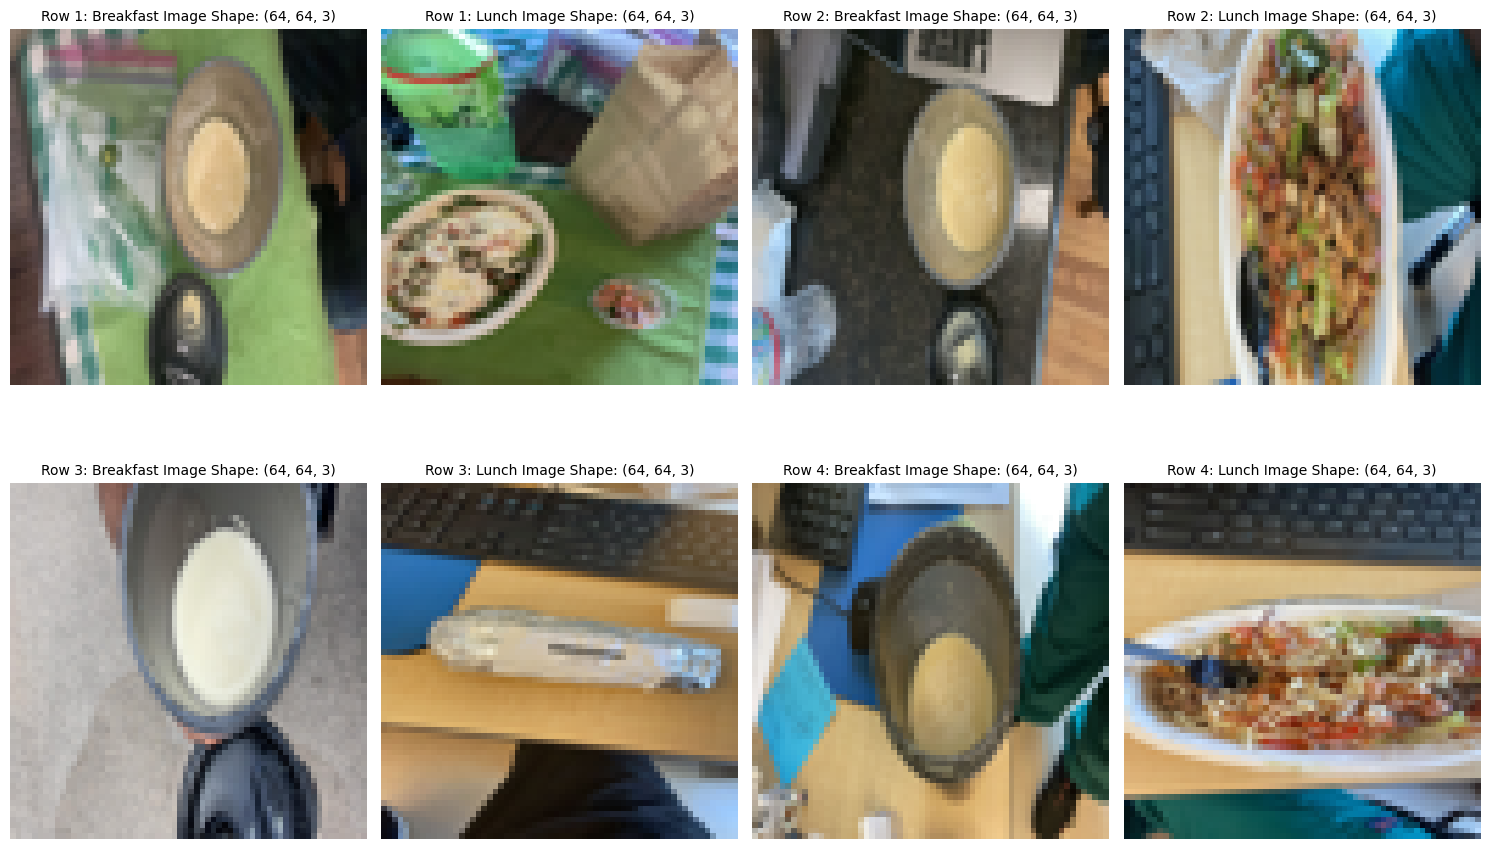

In [7]:
num_images = 8  # Total images
rows = 2
cols = 4

image_arrays = []
titles = []

# Collect Breakfast and Lunch images from the dataset
for i in range(num_images // 2):
    for meal, label in [('Image Before Breakfast', 'Breakfast'), ('Image Before Lunch', 'Lunch')]:
        image_string = img_train_df.loc[i, meal]
        image_array = convert_to_image_array(image_string)
        image_arrays.append(image_array)
        titles.append(f"Row {i+1}: {label} Image Shape: {image_array.shape}")

# Display the images in a grid (2 rows, 4 images per row)
display_images_in_grid(image_arrays, titles, rows=rows, cols=cols)

#### Image Preprocessing 
The following functions help prepare and preprocess the image data to eventually be loaded on to a Pytorch dataloader.

- **preprocess_image** : Transforms the single image to a normalizes, resizes and converts a single image into a Tensor
  - The images are resized to **224x224 pixels** to match the input requirements of the **ResNet model**, which will be used for image feature extraction.
- **preprocess_images** : Processes an entire DataFrame of images by applying preprocessing steps to image columns and returns a processed image dataframe

In [8]:
# Function to preprocess a single image string
def preprocess_image(image_string):
    try:
        # Convert string representation of image to an array
        image_list = ast.literal_eval(image_string)
        image_array = np.array(image_list, dtype='uint8')

        # Convert the numpy array to a PIL Image
        image = Image.fromarray(image_array).convert('RGB')

        # Resize and normalize the image (ImageNet standard normalization)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # Apply transformations
        return transform(image)
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None


In [9]:
# Function to preprocess both training and testing image dataframes
def preprocess_images(img_df):
    # Create a new DataFrame to store processed images
    processed_img_df = pd.DataFrame()

    # Retain relevant columns
    processed_img_df['Subject ID'] = img_df['Subject ID']
    processed_img_df['Day'] = img_df['Day']

    # Apply preprocessing to both 'Image Before Breakfast' and 'Image Before Lunch' columns
    processed_img_df['Processed Image Before Breakfast'] = img_df['Image Before Breakfast'].apply(preprocess_image)
    processed_img_df['Processed Image Before Lunch'] = img_df['Image Before Lunch'].apply(preprocess_image)

    return processed_img_df

In [10]:
# Load training and testing image data
img_train_df = pd.read_csv('img_train.csv')
img_test_df = pd.read_csv('img_test.csv')

# Preprocess training images
processed_img_train_df = preprocess_images(img_train_df)

# Preprocess testing images
processed_img_test_df = preprocess_images(img_test_df)

# Display the first few rows of the processed training DataFrame
print("Processed Training Images:")
processed_img_train_df.head()

Processed Training Images:


,Subject ID,Day,Processed Image Before Breakfast,Processed Image Before Lunch
0,1,2,"[[[tensor(0.2796), tensor(0.2796), tensor(0.26...","[[[tensor(-1.4158), tensor(-1.4158), tensor(-1..."
1,1,3,"[[[tensor(-0.9705), tensor(-0.9705), tensor(-1...","[[[tensor(-1.4329), tensor(-1.4329), tensor(-1..."
2,1,4,"[[[tensor(1.2899), tensor(1.2899), tensor(1.28...","[[[tensor(-1.2103), tensor(-1.2103), tensor(-1..."
3,1,5,"[[[tensor(0.4337), tensor(0.4337), tensor(0.46...","[[[tensor(-1.6042), tensor(-1.6042), tensor(-1..."
4,1,6,"[[[tensor(0.8789), tensor(0.8789), tensor(0.94...","[[[tensor(-0.8507), tensor(-0.8507), tensor(-0..."


In [11]:
print("\nProcessed Testing Images:")
processed_img_test_df.head()


Processed Testing Images:


,Subject ID,Day,Processed Image Before Breakfast,Processed Image Before Lunch
0,4,2,"[[[tensor(-1.1760), tensor(-1.1760), tensor(-1...","[[[tensor(-1.4843), tensor(-1.4843), tensor(-1..."
1,4,3,"[[[tensor(-1.1589), tensor(-1.1589), tensor(-1...","[[[tensor(-1.6213), tensor(-1.6213), tensor(-1..."
2,4,6,"[[[tensor(1.7694), tensor(1.7694), tensor(1.73...","[[[tensor(-1.1760), tensor(-1.1760), tensor(-1..."
3,4,7,"[[[tensor(0.3823), tensor(0.3823), tensor(0.38...","[[[tensor(-0.2342), tensor(-0.2342), tensor(-0..."
4,4,8,"[[[tensor(1.3242), tensor(1.3242), tensor(1.34...","[[[tensor(-0.6109), tensor(-0.6109), tensor(-0..."


### Preprocessing Training and Testing Time Series Data

#### Loading the Dataset

We load both the training and testing datasets from CSV files (`cgm_train.csv` and `cgm_test.csv`) using `pandas`. Each dataset contains time stamps of the participant's Breakfast and Lunch time and their gluocose level every five minutes, along with additional metadata such as subject IDs and days.

In [12]:
# Load CGM data for training and testing
cgm_train_df = pd.read_csv('cgm_train.csv')
cgm_test_df = pd.read_csv('cgm_test.csv')

In [13]:
# Printing the first 5 rows of the cmg training data
cgm_train_df.head()

,Subject ID,Day,Breakfast Time,Lunch Time,CGM Data
0,1,2,2021-09-19 08:41:00,2021-09-19 12:24:00,"[('2021-09-19 08:20:00', 98.26666666666667), (..."
1,1,3,2021-09-20 09:50:00,2021-09-20 15:20:00,"[('2021-09-20 09:10:00', 97.18333333333334), (..."
2,1,4,2021-09-21 09:34:00,2021-09-21 13:09:00,"[('2021-09-21 09:20:00', 107.36666666666666), ..."
3,1,5,2021-09-22 09:46:00,2021-09-22 13:50:00,"[('2021-09-22 09:25:00', 107.28333333333333), ..."
4,1,6,2021-09-23 09:07:00,2021-09-23 13:17:00,"[('2021-09-23 08:55:00', 103.0), ('2021-09-23 ..."


#### Time Series Preprocessing
The following code focuses on extracting, scaling, and normalizing glucose data from Continuous Glucose Monitoring (CGM) dataset, specifically within a 2-hour window around meal times (breakfast and lunch).

We chose a two-hour meal window to capture change in glucose levels around meal times effectively.By focusing on this window, we aim to improve the accuracy of predicting calorie intake based on glucose dynamics.

- **convert_meal_times**: Converts meal time columns to datetime format for easier manipulation and filtering.



In [14]:
# Function to convert meal times to datetime
def convert_meal_times(df, meal_cols):
    for col in meal_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

- **extract_meal_window**: Extracts glucose readings within a 2-hour time window before and after a specific meal time for a given row.


In [15]:
# Function to extract CGM data within a time window of the meal
def extract_meal_window(row, meal_time_col):
    try:
        meal_time = row[meal_time_col]
        cgm_series = ast.literal_eval(row['CGM Data'])  # Parse CGM data string to list of tuples
        cgm_series = [(datetime.strptime(t, "%Y-%m-%d %H:%M:%S"), v) for t, v in cgm_series]
        
        # Filter glucose readings within the time window
        filtered_series = [
            v for t, v in cgm_series if meal_time - time_window <= t <= meal_time + time_window
        ]
        return filtered_series
    except Exception as e:
        print(f"Error extracting meal window for row: {e}")
        return []

- **extract_glucose_windows**: Applies `extract_meal_window` to retrieve glucose readings for breakfast and lunch across the entire dataset.

In [16]:
# Function to extract glucose windows for breakfast and lunch
def extract_glucose_windows(df):
    df['glucose_breakfast'] = df.apply(lambda row: extract_meal_window(row, 'Breakfast Time'), axis=1)
    df['glucose_lunch'] = df.apply(lambda row: extract_meal_window(row, 'Lunch Time'), axis=1)
    return df

- **scale_glucose_values**: Standardizes glucose values using a `StandardScaler`, fitting it on training data and applying it to both breakfast and lunch readings.

In [17]:
# Function to scale glucose values using StandardScaler
def scale_glucose_values(df, scaler=None):
    breakfast_flat = np.concatenate(df['glucose_breakfast'].values)
    lunch_flat = np.concatenate(df['glucose_lunch'].values)
    
    # Combine both breakfast and lunch data to fit the scaler
    combined_flat = np.concatenate((breakfast_flat, lunch_flat))
    
    # Fit the scaler if not provided (for training data)
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(combined_flat.reshape(-1, 1))
    
    # Apply scaling to each glucose sequence
    df['scaled_glucose_breakfast'] = df['glucose_breakfast'].apply(
        lambda x: scaler.transform(np.array(x).reshape(-1, 1)).flatten().tolist() if len(x) > 0 else x
    )
    df['scaled_glucose_lunch'] = df['glucose_lunch'].apply(
        lambda x: scaler.transform(np.array(x).reshape(-1, 1)).flatten().tolist() if len(x) > 0 else x
    )
    
    return df, scaler

- **pad_sequences**: Utility function to normalize sequence lengths by cutting or truncating longer sequences or padding shorter ones with zeros to make sure the sequences are fixed length.

In [19]:
# Global time window for CGM data extraction (2 hours before and after meal)
time_window = timedelta(hours=2)
sequence_length = 48  # Desired sequence length for padding/truncating

# Function to normalize sequence lengths (truncate or pad)
def pad_sequences(df, columns, length=sequence_length):
    def pad_sequence(sequence, length=length):
        if len(sequence) >= length:
            return sequence[:length]  # Truncate if longer
        else:
            return sequence + [0] * (length - len(sequence))  # Pad with zeros if shorter

    for col in columns:
        df[f'padded_{col}'] = df[col].apply(lambda x: pad_sequence(x))
    return df

- **preprocess_cgm_data**: Calls all the above functions to produce a final DataFrame with scaled and normalized CGM data for both breakfast and lunch.

In [20]:
# Function to preprocess CGM data (combining all above functions)
def preprocess_cgm_data(df, scaler=None):
    # Step 1: Convert meal times
    df = convert_meal_times(df, ['Breakfast Time', 'Lunch Time'])
    
    # Step 2: Extract glucose readings within time window
    df = extract_glucose_windows(df)
    
    # Step 3: Scale glucose values using StandardScaler
    df, scaler = scale_glucose_values(df, scaler=scaler)
    
    # Step 4: Normalize sequence lengths by padding/truncating
    df = pad_sequences(df, ['scaled_glucose_breakfast', 'scaled_glucose_lunch'])
    
    # Step 5: Create final processed DataFrame
    processed_df = pd.DataFrame({
        'Subject ID': df['Subject ID'],
        'Day': df['Day'],
        'padded_glucose_breakfast': df['padded_scaled_glucose_breakfast'],
        'padded_glucose_lunch': df['padded_scaled_glucose_lunch']
    })
    
    return processed_df, scaler

#### Sequence Length (`sequence_length`)

Since we are focusing on 2 hours before and 2 hours after each meal, with data sampled every 5 minutes, the total number of timesteps is calculated as follows:

- **Sampling Rate**: 24 samples per hour (1 sample every 5 minutes).
- **Time Window**: 2 hours before + 2 hours after = 4 hours.

#### Calculation:
`Sequence Length = 2 × 24 = 48`

Thus, the sequence length is set to **48** to capture the glucose data within the specified time window.


In [21]:
# Preprocess training CGM data
processed_cgm_train_df, trained_scaler = preprocess_cgm_data(cgm_train_df)

# Preprocess testing CGM data using the same scaler
processed_cgm_test_df, _ = preprocess_cgm_data(cgm_test_df, scaler=trained_scaler)

# Display the first few rows of the processed training DataFrame
print("Processed Training CGM Data:")
processed_cgm_train_df.head()

Processed Training CGM Data:


,Subject ID,Day,padded_glucose_breakfast,padded_glucose_lunch
0,1,2,"[-0.9368138447706694, -0.9975725814922375, -0....","[-1.9559184936735117, -1.8968018849714454, -1...."
1,1,3,"[-0.9581615090241933, -0.9312306095043632, -0....","[-1.063914553480112, -1.0763947264283258, -1.0..."
2,1,4,"[-0.7574934650410685, -0.7216950742159283, -0....","[-0.863246509496987, -0.8668591911398911, -0.8..."
3,1,5,"[-0.7591355930605703, -0.646485610922744, -0.6...","[-0.9384559727901711, -0.9151377549132452, -0...."
4,1,6,"[-0.8435409732629648, -0.8327029283342527, -0....","[-0.7462613093876758, -0.7684628802113407, -0...."


### Preprocessing Training and Testing Tabular Data

#### Loading the Dataset

This dataset contains **static demographic and clinical information** about participants, along with their microbiome data (Viome). Unlike time-series data (such as CGM readings), this dataset provides a one-time snapshot of participant characteristics and is not collected on a day-to-day basis.

In [22]:
demo_viome_train_df = pd.read_csv('demo_viome_train.csv')
demo_viome_test_df = pd.read_csv('demo_viome_test.csv')
demo_viome_train_df.head()

,Subject ID,Age,Gender,Weight,Height,Race,Diabetes Status,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,Viome
0,1,27,0,133.8,65.00,Hispanic/Latino,1,5.4,91.0,2.5,67.0,216.0,74.0,142.0,130.0,13.0,2.9,0.561728,22.263053,"-11.691621427726268,-7.744787588227839,-7.6142..."
1,2,49,1,169.2,62.00,Hispanic/Latino,1,5.5,93.0,14.8,61.0,181.0,91.0,90.0,78.0,12.0,2.0,3.398519,30.943704,"-9.395216776716872,-7.315438412832852,1.103724..."
2,3,59,1,157.0,64.00,Hispanic/Latino,3,6.5,118.0,17.4,154.0,190.0,74.0,116.0,90.0,31.0,2.6,5.069630,26.946045,"-11.007947281293239,-8.444134921199856,0.28806..."
3,5,51,1,172.0,62.50,Hispanic/Latino,3,6.6,144.0,12.9,392.0,269.0,38.0,231.0,157.0,78.0,7.1,4.586667,30.954496,"-6.21833166351615,-5.868646092839025,-6.612900..."
4,6,51,1,197.0,68.75,White,1,5.2,96.0,6.4,75.0,203.0,72.0,131.0,118.0,15.0,2.8,1.517037,29.300575,"-6.7953636871125,-6.50799421035929,-1.85678011..."


#### Preprocessing Tabular Data

We are preprocessing the Numerical and Categorical Columns separtely:
- The numerical data (e.g., Age, Weight, BMI) is standardized using StandardScaler to normalize the data for consistent feature scaling.
- The Categorical variables (e.g., Race, Diabetes Status) are converted into numerical format using one-hot encoding.
    - Missing values in categorical columns are replaced with "Unknown" before encoding.
    - The Gender column is binary and requires no encoding; missing values are replaced with 0.

In [23]:
# Preprocess demographic and viome data
# List of numerical columns
numerical_cols = [
    'Age', 'Weight', 'Height', 'BMI', 'A1C', 'Baseline Fasting Glucose', 
    'Insulin', 'Triglycerides', 'Cholesterol', 'HDL', 'Non-HDL', 
    'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR'
]

# One-hot encode categorical columns
categorical_cols = ['Race', 'Diabetes Status']

In [24]:
# Function to preprocess demographic and viome data
def preprocess_demo_viome_data(df, numerical_scaler=None, viome_scaler=None, encoder=None):
    # Set Subject ID as the index
    df.set_index('Subject ID', inplace=True)

    # Impute missing numerical values using the mean and scale the columns
    if numerical_scaler is None:
        numerical_scaler = StandardScaler()
        numerical_data = pd.DataFrame(
            numerical_scaler.fit_transform(df[numerical_cols].fillna(df[numerical_cols].mean())),  
            columns=numerical_cols,
            index=df.index
        )
    else:
        numerical_data = pd.DataFrame(
            numerical_scaler.transform(df[numerical_cols].fillna(df[numerical_cols].mean())),  
            columns=numerical_cols,
            index=df.index
        )

    # One-hot encode categorical columns
    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoded_data = pd.DataFrame(
            encoder.fit_transform(df[categorical_cols].fillna('Unknown')),
            columns=encoder.get_feature_names_out(categorical_cols),
            index=df.index
        )
    else:
        encoded_data = pd.DataFrame(
            encoder.transform(df[categorical_cols].fillna('Unknown')),
            columns=encoder.get_feature_names_out(categorical_cols),
            index=df.index
        )

    # Add Gender column directly (binary, no encoding needed)
    encoded_data['Gender'] = df['Gender'].fillna(0).astype(int)

    # Split Viome column into separate columns
    viome_data = df['Viome'].str.split(',', expand=True).fillna(0).astype(float)

    # Scale Viome data
    if viome_scaler is None:
        viome_scaler = StandardScaler()
        scaled_viome_data = pd.DataFrame(
            viome_scaler.fit_transform(viome_data),
            columns=[f'Viome_{i}' for i in range(viome_data.shape[1])],
            index=df.index
        )
    else:
        scaled_viome_data = pd.DataFrame(
            viome_scaler.transform(viome_data),
            columns=[f'Viome_{i}' for i in range(viome_data.shape[1])],
            index=df.index
        )

    # Concatenate all processed features into a final DataFrame
    processed_df = pd.concat([numerical_data, encoded_data, scaled_viome_data], axis=1)

    return processed_df, numerical_scaler, viome_scaler, encoder

To maintain consistency between training and testing datasets:
- **Same Scaler and Encoder**: The `StandardScaler` (for numerical and Viome data) and `OneHotEncoder` (for categorical data) fit on the **training data** are reused for **testing data**.
- We did this to ensure that the model interprets features on the same scale during training and inference and to also prevent data leakage, as the testing data is not used to fit scalers or encoders, ensuring unbiased evaluation.

In [25]:
# Preprocess training demographic and viome data
processed_demo_viome_train_df, trained_numerical_scaler, trained_viome_scaler, trained_encoder = preprocess_demo_viome_data(demo_viome_train_df)

# Preprocess testing demographic and viome data using the same scalers and encoder
processed_demo_viome_test_df, _, _, _ = preprocess_demo_viome_data(
    demo_viome_test_df, 
    numerical_scaler=trained_numerical_scaler, 
    viome_scaler=trained_viome_scaler, 
    encoder=trained_encoder
)

In [26]:
processed_demo_viome_train_df.head()

,Age,Weight,Height,BMI,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,Cholesterol,HDL,...,Viome_17,Viome_18,Viome_19,Viome_20,Viome_21,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26
Subject ID,,,,,,,,,,,,,,,,,,,,,
1,-2.121320,-1.393944,0.260163,-1.366764,-0.931655,-1.036424,-1.405640,-0.544819,0.624210,1.304817,...,0.603581,0.095150,0.785660,-0.130032,0.471938,-0.075081,-0.443164,-0.119118,-0.199544,-0.036756
2,-0.092231,-0.297239,-0.659561,0.030992,-0.807434,-0.969856,0.028171,-0.577572,-0.238185,2.343241,...,0.160463,0.893688,0.408496,-0.017819,0.310991,-0.243833,-0.334656,-0.091057,-0.104389,0.024423
3,0.830082,-0.675199,-0.046412,-0.612710,0.434772,-0.137758,0.331253,-0.069903,-0.016427,1.304817,...,-0.131751,-0.831298,-0.770304,0.080012,-1.088635,0.289783,0.061604,0.051831,0.040942,0.066255
5,0.092231,-0.210494,-0.506274,0.032729,0.558993,0.727623,-0.193312,1.229293,1.930124,-0.894198,...,-1.726333,-1.057826,1.034744,-0.633786,-0.263763,-0.411627,-0.083387,0.179690,-0.020963,0.106919
6,0.092231,0.564014,1.409818,-0.233585,-1.180096,-0.870004,-0.951017,-0.501149,0.303892,1.182649,...,0.367603,1.626862,-1.317988,0.091454,-0.280805,0.116046,0.192330,0.126726,0.057324,0.378166



<br></br>
## (b) Data Preparation

### Loading Label 
In the label dataset we will only be using the Lunch Calories column to train the dataset.

In [27]:
label_train_df = pd.read_csv('label_train.csv')
label_train_df = label_train_df[['Subject ID', 'Day', 'Lunch Calories']]
label_train_df.head()

,Subject ID,Day,Lunch Calories
0,1,2,830
1,1,3,435
2,1,4,555
3,1,5,355
4,1,6,1180


### Utility Functions to Merge Datasets

- **convert_to_numeric** : Converts non-numeric columns in a DataFrame to numeric values (where possible) so that we can later transform them into tensors for PyTorch `DataLoader`.

In [28]:
# Function to convert non-numeric columns to numeric where possible
def convert_to_numeric(df, exclude_cols):
    for col in df.columns:
        if col not in exclude_cols:
            if df[col].dtype == 'object':
                try:
                    df[col] = df[col].apply(lambda x: np.array(x) if isinstance(x, list) else x)
                    df[col] = df[col].apply(lambda x: x if isinstance(x, np.ndarray) else pd.to_numeric(x, errors='coerce'))
                except Exception as e:
                    print(f"Error converting column {col}: {e}")
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

- **merge_features** : Merges all the data from the different dataframes into a singular combined dataframe 

In [29]:
# Function to set common index and merge features
def merge_features(img_df, cgm_df, demo_viome_df, label_df=None):
    # Merge all features (Viome, images, and CGM) into a single DataFrame
    combined_features_df = pd.merge(
        demo_viome_df,
        img_df,
        left_index=True,
        right_index=True,
        how='inner'  # Use 'inner' to keep only common samples
    )

    combined_features_df = pd.merge(
        combined_features_df,
        cgm_df,
        left_index=True,
        right_index=True,
        how='inner'
    )

    if label_df is not None:
        # Merge the combined features with the labels using an outer join to inspect missing data
        combined_df = pd.merge(
            combined_features_df,
            label_df,
            left_index=True,
            right_index=True,
            how='outer'  # Use 'outer' to inspect where data might be missing
        )
        # Reset the index to make it easier for conversion to PyTorch tensors
        combined_df.reset_index(inplace=True)
        return combined_df
    else:
        # For test data, no labels are merged
        combined_features_df.reset_index(inplace=True)
        return combined_features_df

- **prepare_data_for_loader** : This function transforms preprocessed data into tensors, making it ready for loading into PyTorch DataLoader for model training and evaluation.
  - The function reshapes the time series data for model input and converts the sequence into a 3D tensor of shape `(batch_size, sequence_length, input_size)`,
  - The function also concatenates the breakfast and lunch images and combines the two images along the channel dimension to create a unified input tensor.


In [30]:
# Function to prepare data for DataLoader
def prepare_data_for_loader(combined_df, image_cols, time_series_cols, include_labels=True):
    # Convert non-numeric columns to numeric where possible, handling any issues
    combined_df = convert_to_numeric(combined_df, exclude_cols=image_cols + time_series_cols)
    combined_df.fillna(0, inplace=True)  # Replace NaNs with 0

    tabular_cols = combined_df.columns.difference(['Subject ID', 'Day'] + image_cols + time_series_cols + (['Lunch Calories'] if include_labels else []))

    # Convert images to tensors directly
    images = torch.stack([
        torch.cat([bf_img, bl_img], dim=0)  # Concatenate along channels
        for bf_img, bl_img in zip(combined_df['Processed Image Before Breakfast'], 
                                  combined_df['Processed Image Before Lunch'])
    ])

    time_series_list = []

    # Iterate over the rows to combine the glucose sequences for breakfast and lunch
    for _, row in combined_df[['padded_glucose_breakfast', 'padded_glucose_lunch']].iterrows():
        combined_series = row['padded_glucose_breakfast'] + row['padded_glucose_lunch']
    
        # Check the length and pad/truncate if necessary
        if len(combined_series) > 48:
            combined_series = combined_series[:48]  # Truncate
        elif len(combined_series) < 48:
            combined_series += [0] * (48 - len(combined_series))  # Pad with zeros
    
        time_series_list.append(combined_series)
    
    # Convert to a numpy array
    time_series_array = np.array(time_series_list)
    
    # Ensure the reshaped array matches (batch_size, sequence_length, input_size)
    batch_size = time_series_array.shape[0]  # Number of samples
    sequence_length = 48  # Fixed number of timesteps
    input_size = 1  # Each timestep has one feature (glucose level)
    
    # Ensure the total number of elements matches before reshaping
    if time_series_array.size == batch_size * sequence_length * input_size:
        time_series_array = time_series_array.reshape(batch_size, sequence_length, input_size)
    else:
        raise ValueError(f"Cannot reshape time_series_array of size {time_series_array.size} into shape ({batch_size}, {sequence_length}, {input_size})")
    
    # Convert the reshaped array to a PyTorch tensor
    time_series = torch.tensor(time_series_array, dtype=torch.float32)

    # Convert tabular data to tensors
    tabular = torch.tensor(combined_df[tabular_cols].values.astype(np.float32))

    if include_labels:
        # Convert labels to tensors
        labels = torch.tensor(combined_df['Lunch Calories'].values.astype(np.float32))
        return images, time_series, tabular, labels
    else:
        return images, time_series, tabular

- **create_dataloader** is a utility function to create Pytorch dataloaders for our training , validation and testing data

In [31]:
# Function to create DataLoader
def create_dataloader(images, time_series, tabular, labels=None, batch_size=32,shuffle=True):
    # Create a custom PyTorch Dataset for multimodal data
    class MultimodalDataset(Dataset):
        def __init__(self, images, time_series, tabular, labels=None):
            self.images = images
            self.time_series = time_series
            self.tabular = tabular
            self.labels = labels

        def __len__(self):
            return len(self.time_series)

        def __getitem__(self, idx):
            x_image = self.images[idx]
            x_time_series = self.time_series[idx]
            x_tabular = self.tabular[idx]
            if self.labels is not None:
                y = self.labels[idx]
                return x_image, x_time_series, x_tabular, y
            else:
                return x_image, x_time_series, x_tabular

    # Create an instance of the dataset
    if labels is not None:
        dataset = MultimodalDataset(images=images, time_series=time_series, tabular=tabular, labels=labels)
    else:
        dataset = MultimodalDataset(images=images, time_series=time_series, tabular=tabular)

    # Create a DataLoader for batching and shuffling
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

In [32]:
processed_img_train_df.set_index(['Subject ID', 'Day'], inplace=True)
processed_cgm_train_df.set_index(['Subject ID', 'Day'], inplace=True)
label_train_df.set_index(['Subject ID', 'Day'], inplace=True)

#### A preview of our combined multimodal training DataFrame before converting it for use with the DataLoader.

In [33]:
combined_train_df = merge_features(processed_img_train_df, processed_cgm_train_df, processed_demo_viome_train_df, label_train_df)
combined_train_df

,Subject ID,Day,Age,Weight,Height,BMI,A1C,Baseline Fasting Glucose,Insulin,Triglycerides,...,Viome_22,Viome_23,Viome_24,Viome_25,Viome_26,Processed Image Before Breakfast,Processed Image Before Lunch,padded_glucose_breakfast,padded_glucose_lunch,Lunch Calories
0,1,2,-2.121320,-1.393944,0.260163,-1.366764,-0.931655,-1.036424,-1.405640,-0.544819,...,-0.075081,-0.443164,-0.119118,-0.199544,-0.036756,"[[[tensor(0.2796), tensor(0.2796), tensor(0.26...","[[[tensor(-1.4158), tensor(-1.4158), tensor(-1...","[-0.9368138447706694, -0.9975725814922375, -0....","[-1.9559184936735117, -1.8968018849714454, -1....",830
1,1,3,-2.121320,-1.393944,0.260163,-1.366764,-0.931655,-1.036424,-1.405640,-0.544819,...,-0.075081,-0.443164,-0.119118,-0.199544,-0.036756,"[[[tensor(-0.9705), tensor(-0.9705), tensor(-1...","[[[tensor(-1.4329), tensor(-1.4329), tensor(-1...","[-0.9581615090241933, -0.9312306095043632, -0....","[-1.063914553480112, -1.0763947264283258, -1.0...",435
2,1,4,-2.121320,-1.393944,0.260163,-1.366764,-0.931655,-1.036424,-1.405640,-0.544819,...,-0.075081,-0.443164,-0.119118,-0.199544,-0.036756,"[[[tensor(1.2899), tensor(1.2899), tensor(1.28...","[[[tensor(-1.2103), tensor(-1.2103), tensor(-1...","[-0.7574934650410685, -0.7216950742159283, -0....","[-0.863246509496987, -0.8668591911398911, -0.8...",555
3,1,5,-2.121320,-1.393944,0.260163,-1.366764,-0.931655,-1.036424,-1.405640,-0.544819,...,-0.075081,-0.443164,-0.119118,-0.199544,-0.036756,"[[[tensor(0.4337), tensor(0.4337), tensor(0.46...","[[[tensor(-1.6042), tensor(-1.6042), tensor(-1...","[-0.7591355930605703, -0.646485610922744, -0.6...","[-0.9384559727901711, -0.9151377549132452, -0....",355
4,1,6,-2.121320,-1.393944,0.260163,-1.366764,-0.931655,-1.036424,-1.405640,-0.544819,...,-0.075081,-0.443164,-0.119118,-0.199544,-0.036756,"[[[tensor(0.8789), tensor(0.8789), tensor(0.94...","[[[tensor(-0.8507), tensor(-0.8507), tensor(-0...","[-0.8435409732629648, -0.8327029283342527, -0....","[-0.7462613093876758, -0.7684628802113407, -0....",1180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,49,6,0.737851,0.186054,-1.272711,0.859217,1.304317,0.860759,1.240499,-0.233667,...,0.694076,-1.919439,-1.441646,0.282074,0.866024,"[[[tensor(-1.0219), tensor(-1.0219), tensor(-1...","[[[tensor(1.1872), tensor(1.1872), tensor(1.20...","[-0.15903632961381742, -0.1527962431397105, -0...","[-0.882952045731009, -0.888141170272635, -0.91...",1180
320,49,7,0.737851,0.186054,-1.272711,0.859217,1.304317,0.860759,1.240499,-0.233667,...,0.694076,-1.919439,-1.441646,0.282074,0.866024,"[[[tensor(-2.1179), tensor(-2.1179), tensor(-2...","[[[tensor(-1.5528), tensor(-1.5528), tensor(-1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1.1982406254753624, -1.2034297500169884, -1....",830
321,49,8,0.737851,0.186054,-1.272711,0.859217,1.304317,0.860759,1.240499,-0.233667,...,0.694076,-1.919439,-1.441646,0.282074,0.866024,"[[[tensor(-0.0801), tensor(-0.0801), tensor(-0...","[[[tensor(-0.9020), tensor(-0.9020), tensor(-0...","[0.16663049921378711, 0.21747078269756437, 0.3...","[-0.09269435762594347, -0.30426613165856026, -...",435
322,49,9,0.737851,0.186054,-1.272711,0.859217,1.304317,0.860759,1.240499,-0.233667,...,0.694076,-1.919439,-1.441646,0.282074,0.866024,"[[[tensor(-0.0116), tensor(-0.0116), tensor(-0...","[[[tensor(-0.9705), tensor(-0.9705), tensor(-0...","[0.38444235972051144, 0.514104788140377, 0.730...","[-0.9762906023594936, -0.9513959415838457, -0....",555


#### Creating the Validation Set with an 80/20 Split of the Training Data and Preparing the Train and Validation Dataloaders

In [34]:
from sklearn.model_selection import train_test_split

# Split the combined training dataframe into train and validation sets
train_df, val_df = train_test_split(combined_train_df, test_size=0.2, random_state=42)

image_cols = ['Processed Image Before Breakfast', 'Processed Image Before Lunch']
time_series_cols = ['padded_glucose_breakfast', 'padded_glucose_lunch']

# Prepare training data
images_train, time_series_train, tabular_train, labels_train = prepare_data_for_loader(train_df, image_cols, time_series_cols, include_labels=True)
train_loader = create_dataloader(images_train, time_series_train, tabular_train, labels_train, batch_size=32,shuffle=True)

# Prepare validation data
images_val, time_series_val, tabular_val, labels_val = prepare_data_for_loader(val_df, image_cols, time_series_cols, include_labels=True)
val_loader = create_dataloader(images_val, time_series_val, tabular_val, labels_val, batch_size=32,shuffle=False)


#### Preparing and Creating the Test Loader

In [35]:
# # Example usage for test data
processed_img_test_df.set_index(['Subject ID', 'Day'], inplace=True)
processed_cgm_test_df.set_index(['Subject ID', 'Day'], inplace=True)

In [36]:
combined_test_df = merge_features(processed_img_test_df, processed_cgm_test_df, processed_demo_viome_test_df)

In [37]:
images_test, time_series_test, tabular_test = prepare_data_for_loader(combined_test_df, image_cols, time_series_cols, include_labels=False)
test_loader = create_dataloader(images_test, time_series_test, tabular_test, batch_size=32)

#### Checking the Shapes of data in the Dataloader

In [38]:
# Example: Iterate through the training DataLoader
for batch_images, batch_time_series, batch_tabular, batch_labels in train_loader:
    print("Batch Images Train:", batch_images.shape)
    print("Batch Time Series Train:", batch_time_series.shape)
    print("Batch Tabular Train:", batch_tabular.shape)
    print("Batch Labels Train:", batch_labels.shape)
    break  # Just to show an example batch

# Example: Iterate through the test DataLoader
for batch_images, batch_time_series, batch_tabular in test_loader:
    print("Batch Images Test:", batch_images.shape)
    print("Batch Time Series Test:", batch_time_series.shape)
    print("Batch Tabular Test:", batch_tabular.shape)
    break  # Just to show an example batch

Batch Images Train: torch.Size([32, 6, 224, 224])
Batch Time Series Train: torch.Size([32, 48, 1])
Batch Tabular Train: torch.Size([32, 47])
Batch Labels Train: torch.Size([32])
Batch Images Test: torch.Size([32, 6, 224, 224])
Batch Time Series Test: torch.Size([32, 48, 1])
Batch Tabular Test: torch.Size([32, 47])


#### Explanation of Batch Shapes

##### **Batch Images Train**: `torch.Size([32, 6, 224, 224])`
- **`32`**: Batch size (number of samples in the batch).
- **`6`**: Number of image channels (3 for breakfast + 3 for lunch, concatenated along the channel dimension).
- **`224 x 224`**: Spatial dimensions of the images after resizing.

##### **Batch Time Series Train**: `torch.Size([32, 48, 1])`
- **`32`**: Batch size (number of samples in the batch).
- **`48`**: Sequence length (2 hours before and 2 hours after the meal, sampled every 5 minutes).
- **`1`**: Input feature per timestep (glucose level).

##### **Batch Tabular Train**: `torch.Size([32, 47])`
- **`32`**: Batch size (number of samples in the batch).
- **`47`**: Number of tabular features (demographic, clinical, and Viome data).

##### **Batch Labels Train**: `torch.Size([32])`
- **`32`**: Batch size (number of samples in the batch).
- Labels are scalar values representing lunch calories for each sample.


<br></br>
## (c) Multimodal Model Implementation

In [42]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultimodalModel(nn.Module):
    def __init__(self, cnn_output_dim=256, lstm_input_dim=1, lstm_hidden_dim=128, demo_viome_dim=47,  dropout_rate=0.3, num_lstm_layers=2, activation_fn=nn.ReLU):
        super(MultimodalModel, self).__init__()
        
        # CNN for image features
        self.cnn = models.resnet18(pretrained=True)
        
        # Modify the first convolutional layer to accept 6 input channels
        self.cnn.conv1 = torch.nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Initialize the weights of the new conv1 layer
        nn.init.kaiming_normal_(self.cnn.conv1.weight, mode='fan_out', nonlinearity='relu')

        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, cnn_output_dim)  # Custom FC layer
        
        # LSTM for time-series
        self.lstm = nn.LSTM(input_size=lstm_input_dim, hidden_size=lstm_hidden_dim, num_layers=num_lstm_layers, batch_first=True)

        # Tabular data processing (Fully connected layers)
        self.fc_tabular = nn.Sequential(
            nn.Linear(demo_viome_dim, 128),
            activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64)
        )
        
        # Joint embedding
        self.fc_joint = nn.Sequential(
            nn.Linear(cnn_output_dim + lstm_hidden_dim + 64, 128),
            activation_fn(),
            nn.Linear(128, 64),
            activation_fn(),
            nn.Linear(64, 1)  # Output layer for calorie prediction
        )

    def forward(self, image_data, time_series_data, tabular_data):
        # CNN forward pass
        cnn_features = self.cnn(image_data)
        
        # LSTM forward pass
        lstm_out, (h_n, _) = self.lstm(time_series_data)
        lstm_features = h_n[-1]  # Last hidden state

        # Process tabular data
        tabular_features = self.fc_tabular(tabular_data)
        
        # Combine features
        joint_features = torch.cat((cnn_features, lstm_features, tabular_features), dim=1)
        output = self.fc_joint(joint_features)
        
        return output

In this section, we have defined the **multimodal model** which encodes data from multiple modalities (like image data, tabular dataand time series data ) into a joint embedding and predicts the target label (lunch calories). 

The multimodal model is designed to process and combine three types of data,
1. **Image Data**: Encoded using a pre trained Convolutional Neural Network (ResNet18).
2. **Time-Series Data**: Encoded using a Long Short-Term Memory network.
3. **Tabular Data**: Encoded using fully connected layers.

The features extracted from each modality are concatenated to form a **joint embedding**, which is used for predicting the label.

#### CNN for Image Features
- **Base Model**: A pre-trained ResNet-18 architecture is used. ResNet-18 is computationally efficient and has been proven effective for image feature extraction. It has been pre-trained on large datasets like ImageNet.
- **Modification**:
  - The first convolutional layer is updated to accept 6 input channels instead of the default 3 for RGB images. This is done to incorporate the 'Preocessed Image before Breakfast' and 'Processed Image Before Lunch'
  - The weights of the modified layer are initialized using`kaiming_normal_`, ensuring a proper starting point for training.
  - The original fully connected (FC) layer of ResNet-18 is replaced with a custom FC layer to reduce the output dimension to `cnn_output_dim`.

#### LSTM for Time-Series Features
- **Structure**:
  - An input size of `lstm_input_dim` (default: 1) and a hidden size of `lstm_hidden_dim` (default: 128).
  - The network contains `num_lstm_layers` layers (default: 2).
- **Output**:
  - The last hidden state of the LSTM (`h_n[-1]`) is used as the feature representation of the time-series data.

#### Fully Connected Layers for Tabular Data
- **Input Size**: `demo_viome_dim` (default: 47). This represents the number of features in the tabular data.
- **Architecture**:
  - A sequential model consisting of:
    1. Linear layer with 128 neurons.
    2. Activation function - default: ReLU.
    3. Dropout layer - default: 30%. (Used to prevent overfitting. Tuning with different droptouts in the later sections exhibits its need)
    4. Another Linear layer reducing the dimensionality to 64.
- **Output**:
  - The processed tabular data features are passed forward for combination with other modalities.

#### Joint Embedding and Prediction 
- The features from the CNN, LSTM, and tabular processing layers are concatenated to form a **joint embedding**.
- A fully connected network processes this joint embedding.
  1. Linear layer with 128 neurons followed by an activation function.
  2. Another Linear layer with 64 neurons followed by an activation function.
  3. Final Linear layer to predict the target label (calorie prediction).

Concatenation allows the model to combine complementary information from different data modalities, creating a richer feature representation for prediction.

#### Key Hyperparameters
- **`cnn_output_dim`**: Output dimension of the CNN features (default: 256).
- **`lstm_input_dim`**: Input size for the LSTM (default: 1).
- **`lstm_hidden_dim`**: Hidden size for the LSTM (default: 128).
- **`demo_viome_dim`**: Number of features in the tabular data (default: 47).
- **`dropout_rate`**: Dropout rate for the tabular data processing layers (default: 0.3).
- **`num_lstm_layers`**: Number of layers in the LSTM (default: 2).
- **`activation_fn`**: Activation function for the fully connected layers (default: ReLU).

<br></br>
## (d) Model Training

In [47]:
import matplotlib.pyplot as plt

# Define the RMSRE loss
def rmsre_loss(predictions, targets):
    epsilon = 1e-6  # To avoid division by zero
    relative_error = (predictions - targets) / (targets + epsilon)
    rmsre = torch.sqrt(torch.mean(relative_error ** 2))
    return rmsre

# Model Intialization
model = MultimodalModel(cnn_output_dim=256, lstm_input_dim=1, lstm_hidden_dim=128, demo_viome_dim=47,  dropout_rate=0.3, num_lstm_layers=2, activation_fn=nn.ReLU)

# Only Freeze the required pretrained CNN parameters
for name, param in model.cnn.named_parameters():
    if name not in ['conv1.weight', 'fc.weight', 'fc.bias']:
        param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = rmsre_loss  # Defined RMSRE loss earlier

num_epochs = 10
training_losses = []  # List to store training losses for plotting

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, time_series, tabular, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(images, time_series, tabular)
        loss = criterion(predictions.squeeze(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    training_losses.append(average_loss)  # Store the average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {average_loss:.4f}")

# Validation phase after training
model.eval()
total_val_loss = 0
with torch.no_grad():
    for val_images, val_time_series, val_tabular, val_labels in val_loader:
        val_predictions = model(val_images, val_time_series, val_tabular)
        val_loss = criterion(val_predictions.squeeze(), val_labels)
        total_val_loss += val_loss.item()

print(f"Validation Loss: {total_val_loss / len(val_loader):.4f}")

Epoch 1, Loss: 0.9931
Epoch 2, Loss: 0.9176
Epoch 3, Loss: 0.6111
Epoch 4, Loss: 0.4056
Epoch 5, Loss: 0.3676
Epoch 6, Loss: 0.3480
Epoch 7, Loss: 0.3474
Epoch 8, Loss: 0.3283
Epoch 9, Loss: 0.3324
Epoch 10, Loss: 0.3192
Validation Loss: 0.4162


In this section, we train the model with one combination of hyperparameters. This also includes declaration of the loss function, optimizer, and the training loop. The goal here is to minimize the **RMSRE**, and the performance of this is visualized through a training curve below.


**Loss Function - RMSRE**
It is as defined in the project description. The small constant `epsilon` avoids division by zero.

**Freezing CNN Parameters**
Pre-trained parameters in the CNN are frozen except for the modified layers (`conv1.weight`, `fc.weight`, `fc.bias`).
  - **Why freeze parameters?**
    - Reduces the number of trainable parameters thereby speeding up training.
    - Ensures the model retains knowledge from the pre-trained ResNet-18.

**Optimizer**
- **Adam Optimizer**:
  - Learning rate: `0.001`.
  - **Why Adam?**:
    - Combines the advantages of momentum and adaptive learning rates.
    - Works well in scenarios with sparse gradients and diverse modalities.


Training runs for `10 epochs`. The training loss is computed at each epoch and averaged over all training batches.

**Observations**
- **Training Loss**
  - The loss decreases significantly over the first few epochs and stabilizes towards the end.
  - Initial loss (Epoch 1): `0.9931`.
  - Final loss (Epoch 10): `0.3192`.
- **Validation Loss**:
  - The validation loss is `0.4162` which is slightly higher than the training loss. This indicates reasonable genralization.
- **Training Curve**:

The model does not exhibit severe overfitting, as evidenced by the relatively small gap between training and validation losses.

Further improvement could involve,
  - Increasing the number of epochs for better convergence.
  - Tuning the learning rate or optimizer parameters for better performance. (Performed in the Result Analysis section)

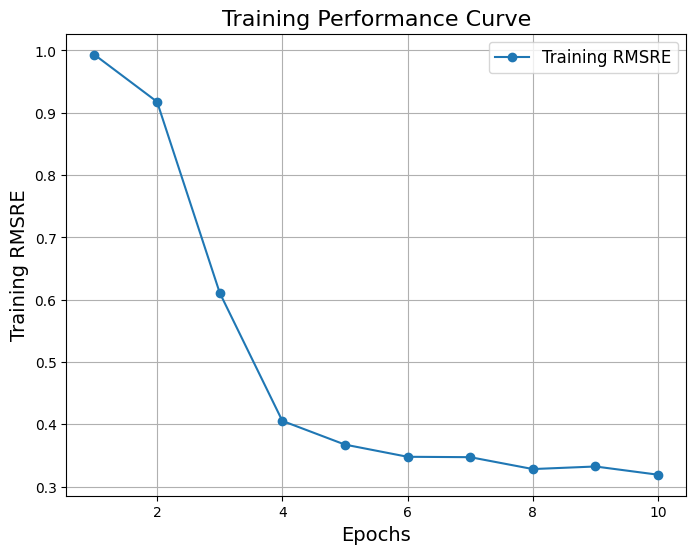

In [48]:
# Plotting the training curve
epochs = range(1, len(training_losses) + 1)  # x-axis for epochs
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_losses, marker='o', linestyle='-', label='Training RMSRE')
plt.title('Training Performance Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training RMSRE', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

The training curve plots the **training RMSRE** against the number of epochs. It provides a clear visual representation of model performance over time.

The curve shows a consistent decrease in loss, suggesting that the model is learning effectively.

<br></br>
## (d) Result Analysis 

In [49]:
import torch.optim as optim

# Define 10 custom hyperparameter combinations
hyperparameter_combinations = [
    {'learning_rate': 0.001, 'dropout_rate': 0.3, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': optim.Adam, 'activation': nn.ReLU},
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': optim.Adam, 'activation': nn.ReLU},
    {'learning_rate': 0.001, 'dropout_rate': 0.6, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': optim.Adam, 'activation': nn.ReLU},
    {'learning_rate': 0.005, 'dropout_rate': 0.7, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': optim.Adam, 'activation': nn.ReLU},
    {'learning_rate': 0.005, 'dropout_rate': 0.6, 'cnn_output_dim': 128, 'lstm_hidden_dim': 64, 'num_lstm_layers': 1, 'optimizer': optim.AdamW, 'activation': nn.LeakyReLU},
    {'learning_rate': 0.005, 'dropout_rate': 0.5, 'cnn_output_dim': 128, 'lstm_hidden_dim': 64, 'num_lstm_layers': 1, 'optimizer': optim.AdamW, 'activation': nn.LeakyReLU},
    {'learning_rate': 0.001, 'dropout_rate': 0.6, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': optim.AdamW, 'activation': nn.LeakyReLU},
    {'learning_rate': 0.001, 'dropout_rate': 0.5, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': optim.SGD, 'activation': nn.ReLU},
    {'learning_rate': 0.0005, 'dropout_rate': 0.4, 'cnn_output_dim': 128, 'lstm_hidden_dim': 256, 'num_lstm_layers': 3, 'optimizer': optim.RMSprop, 'activation': nn.ELU},
    {'learning_rate': 0.01, 'dropout_rate': 0.3, 'cnn_output_dim': 64, 'lstm_hidden_dim': 128, 'num_lstm_layers': 1, 'optimizer': optim.SGD, 'activation': nn.Tanh},
    {'learning_rate': 0.003, 'dropout_rate': 0.7, 'cnn_output_dim': 512, 'lstm_hidden_dim': 256, 'num_lstm_layers': 2, 'optimizer': optim.AdamW, 'activation': nn.ReLU6},
]

# Initializing values for best model
best_hparams = None
best_val_loss = float('inf')
best_model = None

i=1

# Iterate over the 10 custom hyperparameter combinations
for hparams in hyperparameter_combinations:
    # Initialize the model with hyperparameters
    model = MultimodalModel(
        cnn_output_dim=hparams['cnn_output_dim'],
        lstm_input_dim=1,
        lstm_hidden_dim=hparams['lstm_hidden_dim'],
        demo_viome_dim=47,
        dropout_rate=hparams['dropout_rate'],
        num_lstm_layers=hparams['num_lstm_layers'],
        activation_fn=hparams['activation']
    )
    
    # Only Freeze the required pretrained CNN parameters
    for name, param in model.cnn.named_parameters():
        if name not in ['conv1.weight', 'fc.weight', 'fc.bias']:
            param.requires_grad = False
            
    # Loss and optimizer
    optimizer = hparams['optimizer'](model.parameters(), lr=hparams['learning_rate'])
    criterion = rmsre_loss  # Defined RMSRE loss earlier

    print(f"\nModel Combination {i}:")
    i += 1

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, time_series, tabular, labels in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(images, time_series, tabular)
            loss = criterion(predictions.squeeze(), labels)
    
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {average_loss:.4f}")

    # Validation phase after training
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_images, val_time_series, val_tabular, val_labels in val_loader:
            val_predictions = model(val_images, val_time_series, val_tabular)
            val_loss = criterion(val_predictions.squeeze(), val_labels)
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    print(f"\nHyperparameters: {hparams}")
    print(f"\nValidation Loss: {average_val_loss:.2f}%")

    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_hparams = hparams
        best_model = model

print(f"\nBest Hyperparameters: {best_hparams}, Best Validation Loss: {best_val_loss:.2f}%")
torch.save(best_model.state_dict(), "best_model.pth")


Model Combination 1:
Epoch 1, Loss: 0.9933
Epoch 2, Loss: 0.9108
Epoch 3, Loss: 0.5816
Epoch 4, Loss: 0.4552
Epoch 5, Loss: 0.4132
Epoch 6, Loss: 0.3818
Epoch 7, Loss: 0.3455
Epoch 8, Loss: 0.3343
Epoch 9, Loss: 0.3398
Epoch 10, Loss: 0.3248

Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': <class 'torch.optim.adam.Adam'>, 'activation': <class 'torch.nn.modules.activation.ReLU'>}

Validation Loss: 0.41%

Model Combination 2:
Epoch 1, Loss: 0.9941
Epoch 2, Loss: 0.9194
Epoch 3, Loss: 0.6467
Epoch 4, Loss: 0.3927
Epoch 5, Loss: 0.3990
Epoch 6, Loss: 0.3562
Epoch 7, Loss: 0.3357
Epoch 8, Loss: 0.3513
Epoch 9, Loss: 0.3478
Epoch 10, Loss: 0.3461

Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'cnn_output_dim': 256, 'lstm_hidden_dim': 128, 'num_lstm_layers': 2, 'optimizer': <class 'torch.optim.adam.Adam'>, 'activation': <class 'torch.nn.modules.activation.ReLU'>}

Validation Loss

In this section, 11 different combinations of hypeparameters were used to train the model. The model with the least **validation loss** after training for 10 epochs were chosen as the best model. 

The parameters use are as follows:
- **Learning Rate**: Ranged from 0.0005 to 0.01 to control the step size during optimization.
- **Dropout Rate**: Tested values between 0.3 and 0.7 to prevent overfitting.
- **CNN Output Dimensions**: Feature sizes from 64 to 512 for convolutional layers.
- **LSTM Hidden Dimensions**: Layer sizes between 64 and 256 for the network.
- **Number of LSTM Layers**: 1–3 layers to control model depth.
- **Optimizer Types**: Adam, AdamW, RMSprop, and SGD.
- **Activation Functions**: ReLU, LeakyReLU, Tanh, ELU, and ReLU6.

The metrics used are as follows,
1. **Training Loss**: Monitored during each epoch to observe convergence trends.
2. **Validation Loss**: Calculated after each training phase to assess the model's ability to generalize to unseen data.

#### Observations
**Poor Performing Combinations**
1. **High Dropout Rate (0.7, 0.5)**: This led to excessive information loss when paired with smaller learning rate. These combinations resulted in high validation loss of >0.5.
2. **SGD Optimizer**: Despite its simplicity, SGD struggled to converge compared to adaptive optimizers like Adam and AdamW.
3. **LeakyReLU with AdamW**: Although promising in theory, this combination showed unstable training and higher variance in validation loss across epochs.

### Best Performing Combination
The model achieving the lowest **validation loss (0.38%)** had the following configuration:
- **Learning Rate**: 0.001  
- **Dropout Rate**: 0.6  
- **CNN Output Dimensions**: 256  
- **LSTM Hidden Dimensions**: 128  
- **Number of LSTM Layers**: 2  
- **Optimizer**: Adam  
- **Activation Function**: ReLU  

This setup balanced regularization, model capacity, and convergence stability effectively. The relatively high dropout rate of 0.6 worked well with the robust optimizer like Adam. The ReLU activation supported efficient gradient flow.

**Note**: Since the Validation Loss of few combinations are close in value, different runs gives slightly different values. The best performing model used to upload test results to Kaggle is with the combination mentioned in this section.

In [50]:
import torch

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations (not needed during inference)
with torch.no_grad():
    all_predictions = []

    for images, time_series, tabular in test_loader:
        # Forward pass: get predictions
        predictions = best_model(images, time_series, tabular)
        
        # Store predictions and labels
        all_predictions.extend(predictions.squeeze().tolist())

# Print out the predictions
for i, pred in enumerate(all_predictions):
    print(f"Sample {i + 1}: Predicted Lunch Calories = {pred:.2f}")
    
# Optionally, convert to tensor for evaluation
predictions_tensor = torch.tensor(all_predictions)

Sample 1: Predicted Lunch Calories = 605.13
Sample 2: Predicted Lunch Calories = 424.84
Sample 3: Predicted Lunch Calories = 473.44
Sample 4: Predicted Lunch Calories = 499.07
Sample 5: Predicted Lunch Calories = 553.76
Sample 6: Predicted Lunch Calories = 578.75
Sample 7: Predicted Lunch Calories = 493.42
Sample 8: Predicted Lunch Calories = 507.94
Sample 9: Predicted Lunch Calories = 478.71
Sample 10: Predicted Lunch Calories = 456.21
Sample 11: Predicted Lunch Calories = 511.00
Sample 12: Predicted Lunch Calories = 522.72
Sample 13: Predicted Lunch Calories = 519.26
Sample 14: Predicted Lunch Calories = 484.30
Sample 15: Predicted Lunch Calories = 405.30
Sample 16: Predicted Lunch Calories = 581.62
Sample 17: Predicted Lunch Calories = 461.58
Sample 18: Predicted Lunch Calories = 531.07
Sample 19: Predicted Lunch Calories = 570.24
Sample 20: Predicted Lunch Calories = 477.98
Sample 21: Predicted Lunch Calories = 512.91
Sample 22: Predicted Lunch Calories = 569.02
Sample 23: Predicte

In [51]:
# Save the predictions to a CSV file in the required format
output_df = pd.DataFrame({
    'row_id': range(len(all_predictions)),
    'label': all_predictions
})
output_df.to_csv('predictions.csv', index=False, header=True)

In [52]:
import pickle
# Define the file name for saving the model
filename = 'best_model.pkl'

# Save the model to a pickle file
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model has been saved to {filename}")

Model has been saved to best_model.pkl


The best model from the hyperparameter tuning is then run with the test data to create a csv file to upload to Kaggele in the required format. A pickle file of the best model is also saved.